In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
grid_resolution        = 100
quadrature_order       = 5
ϵ                      = 1                # perturbation
selected_ev            = 2
t_initial              = minimum(Time)
t_end                  = t_initial+80     # parameter value corresponding to ϵ=0
scale                  = 1
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5();

In [5]:
T(x, param) = flow(interp_rhs, x, [t_initial, t_end + scale*param], p=UV,
        tolerance=solver_tolerance,solver=solver)[end]

T (generic function with 1 method)

In [6]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [7]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [8]:
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

202.968623 seconds (94.83 M allocations: 5.388 GiB, 0.67% gc time)


In [9]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀[:,selected_ev])
λ₀ = real.(λ₀[selected_ev])
u₀ = u₀ ./ sqrt(u₀'*M*u₀)        # L2 normalization
if u₀[Int(floor(0.75*lat_resolution*lon_resolution+0.75*lon_resolution))]<0
    u₀ = -u₀
end
λ₀

  3.295278 seconds (9.40 M allocations: 599.743 MiB, 4.31% gc time)


-12.373841345234917

In [10]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

2342.485292 seconds (114.38 M allocations: 9.102 GiB, 0.06% gc time)


In [11]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  0.817236 seconds (2.38 M allocations: 170.766 MiB, 3.18% gc time)


-0.6188869857221193

In [12]:
# calculate the exact uϵ
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
if uϵ[Int(floor(0.75*lat_resolution*lon_resolution+0.75*lon_resolution))]<0
    uϵ = -uϵ
end
λϵ

-13.148540729442555

In [13]:
λ₀ + ϵ*λ_dot 

-12.992728330957036

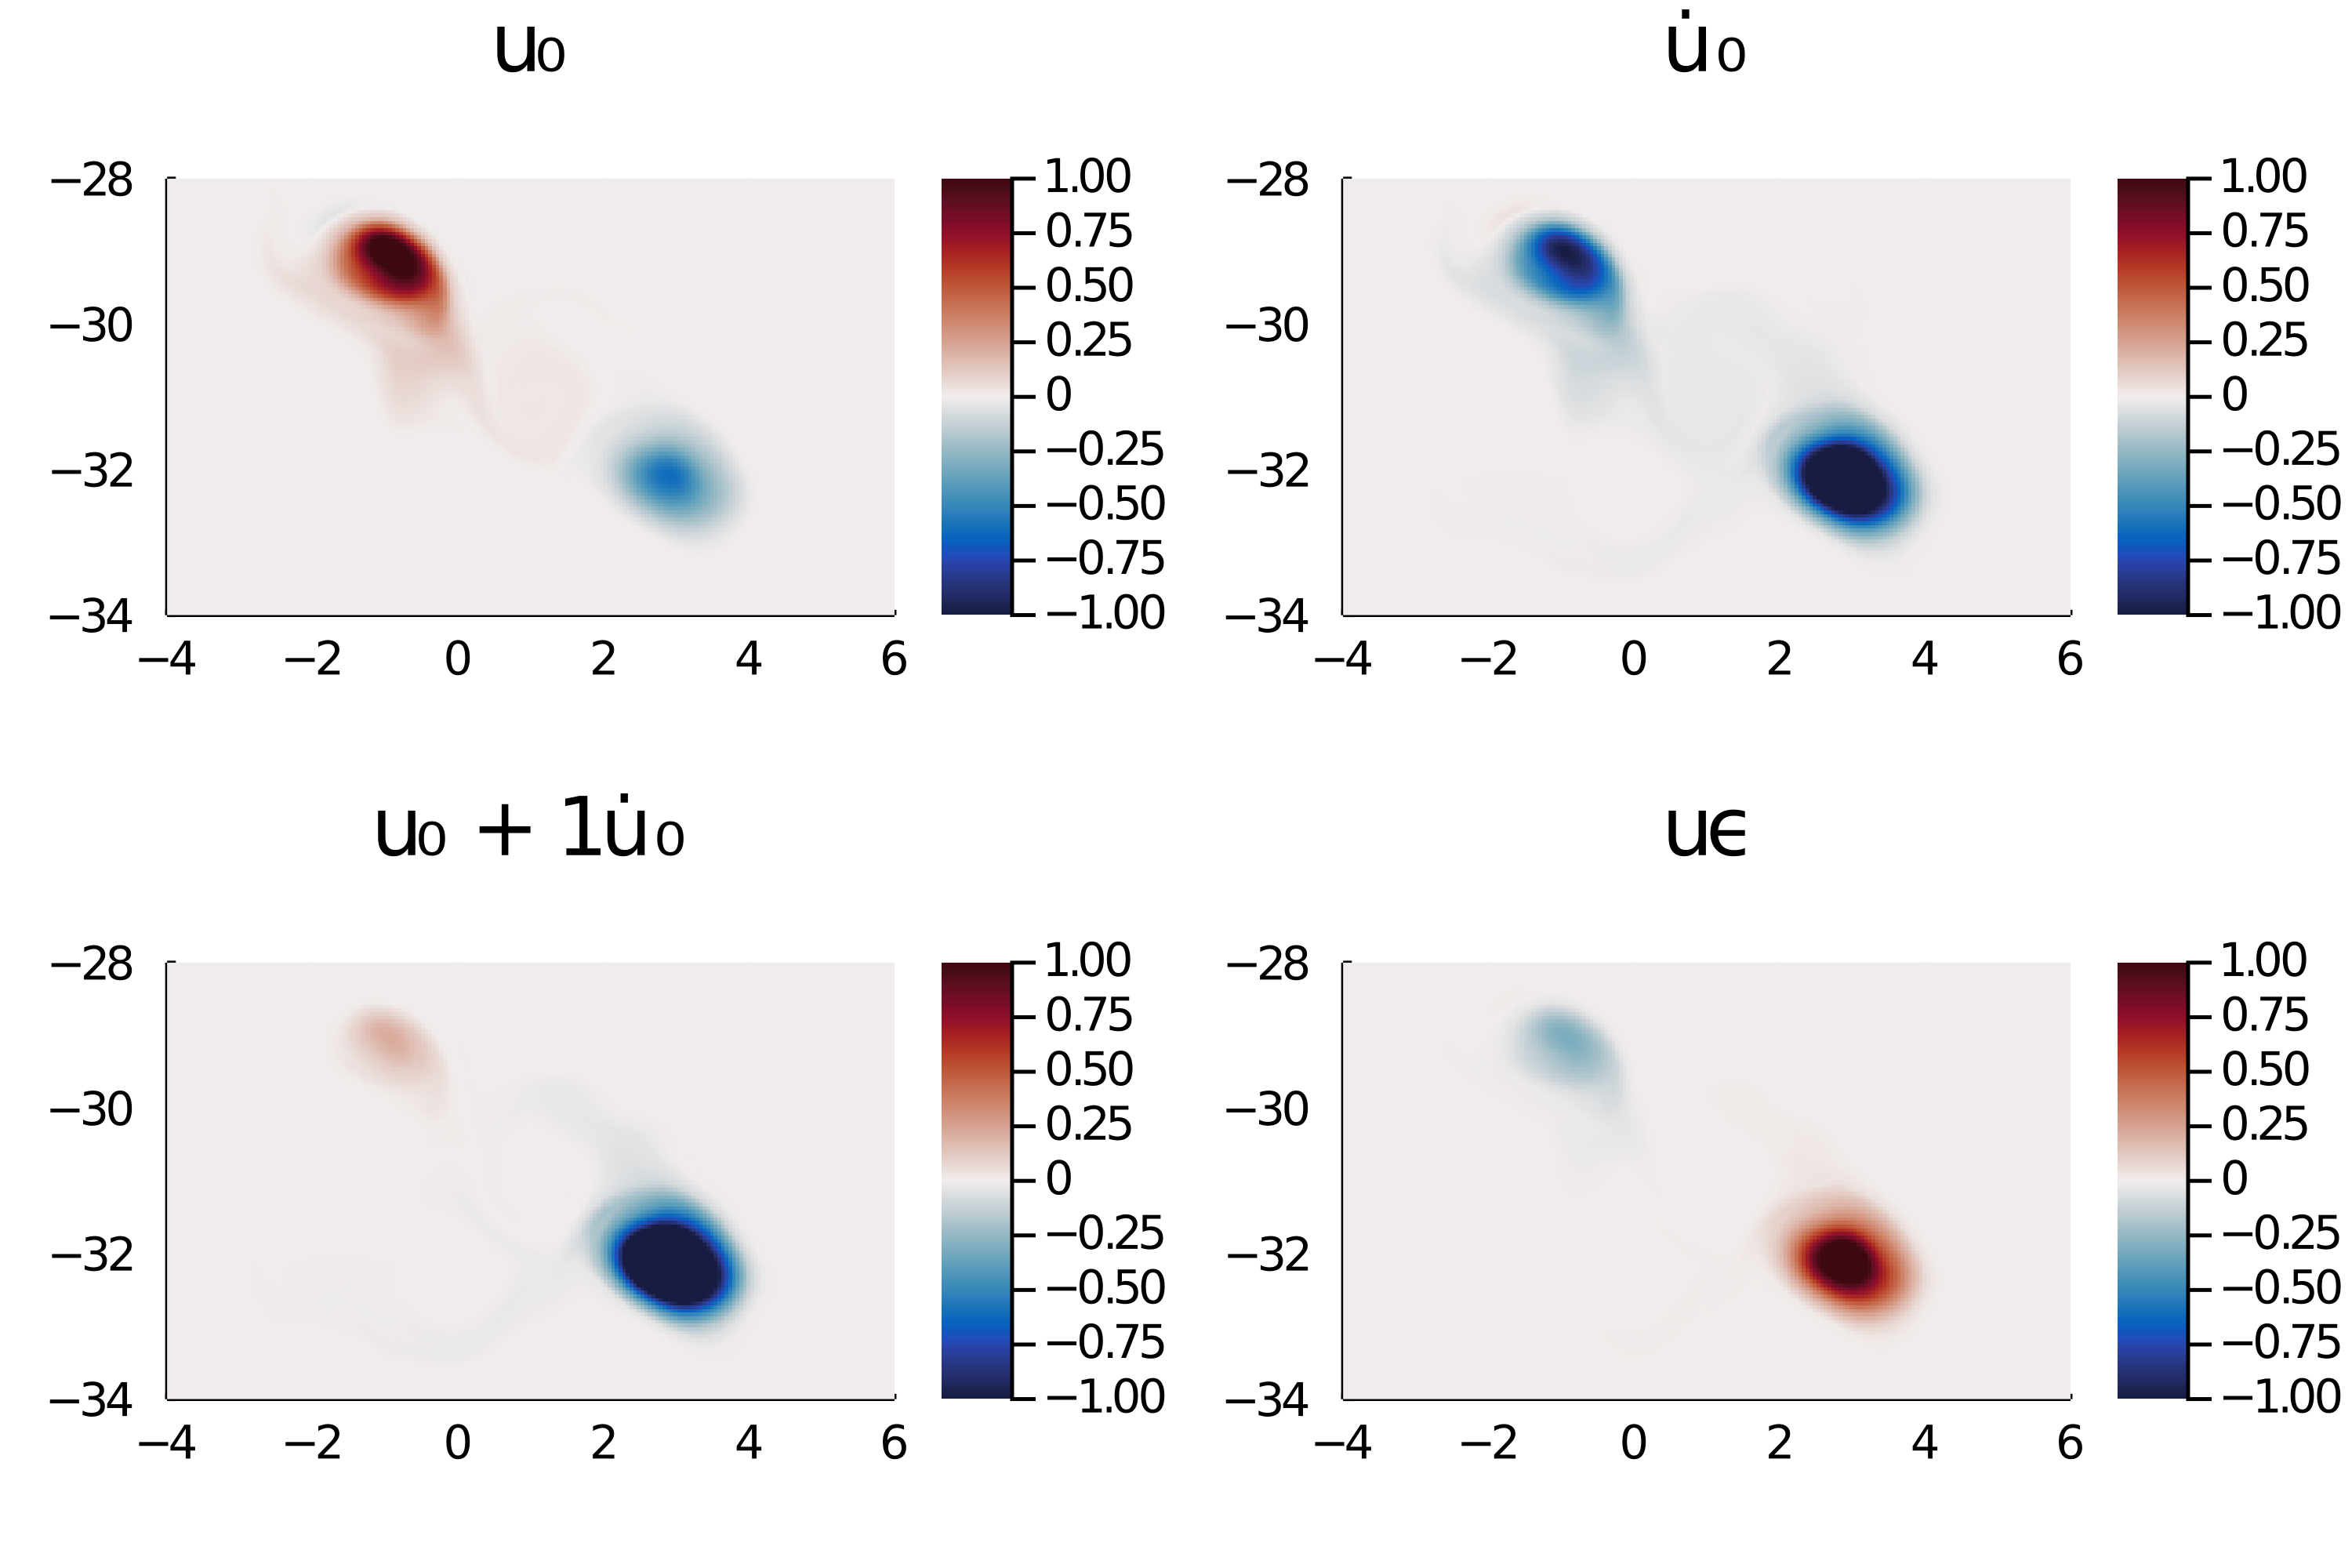

In [14]:
color =    :balance
xticks =   -4:2:6
yticks =   -34:2:-28
colorbar = :left
cmin =     -1
cmax =     1
cmin_lr =  -1
cmax_lr =  1
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,           lon_resolution, lat_resolution, title="u₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       lon_resolution, lat_resolution, title="u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, lon_resolution, lat_resolution, title="u₀ + $(ϵ)u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          lon_resolution, lat_resolution, title="uϵ", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)

In [15]:
using Contour

In [23]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x->T(x,0),tolerance=1e-10)
end
function dynamic_cheeger_value_levelset_nonnegative(levelset)
    if level(levelset) < 0
        return Inf
    end
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: $(level(levelset))"
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x->T(x,0),tolerance=1e-10)
end

best_levelset, best_value = get_minimal_levelset(
    ctx,u₀,dynamic_cheeger_value_levelset_nonnegative,n_candidates=1000,bdata=bdata)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0005851767396917174
└ @ Main In[23]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.00243186299555187
└ @ Main In[23]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.004278549251412023
└ @ Main In[23]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.006125235507272175
└ @ Main In[23]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.007971921763132439
└ @ Main In[23]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.009818608018992592
└ @ Main In[23]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.011665294274852744
└ @ Main In[23]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.017205353042433202
└ @ Main In[23]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.024592098065873924
└ @ Main In[23]:15
┌ Warning: Currentl

Dynamic Cheeger value:	2.840465877757568
Levelset:		0.011665294274852744


2.840465877757568	15.399901967926553	28.457926156226268	7.720182183419993


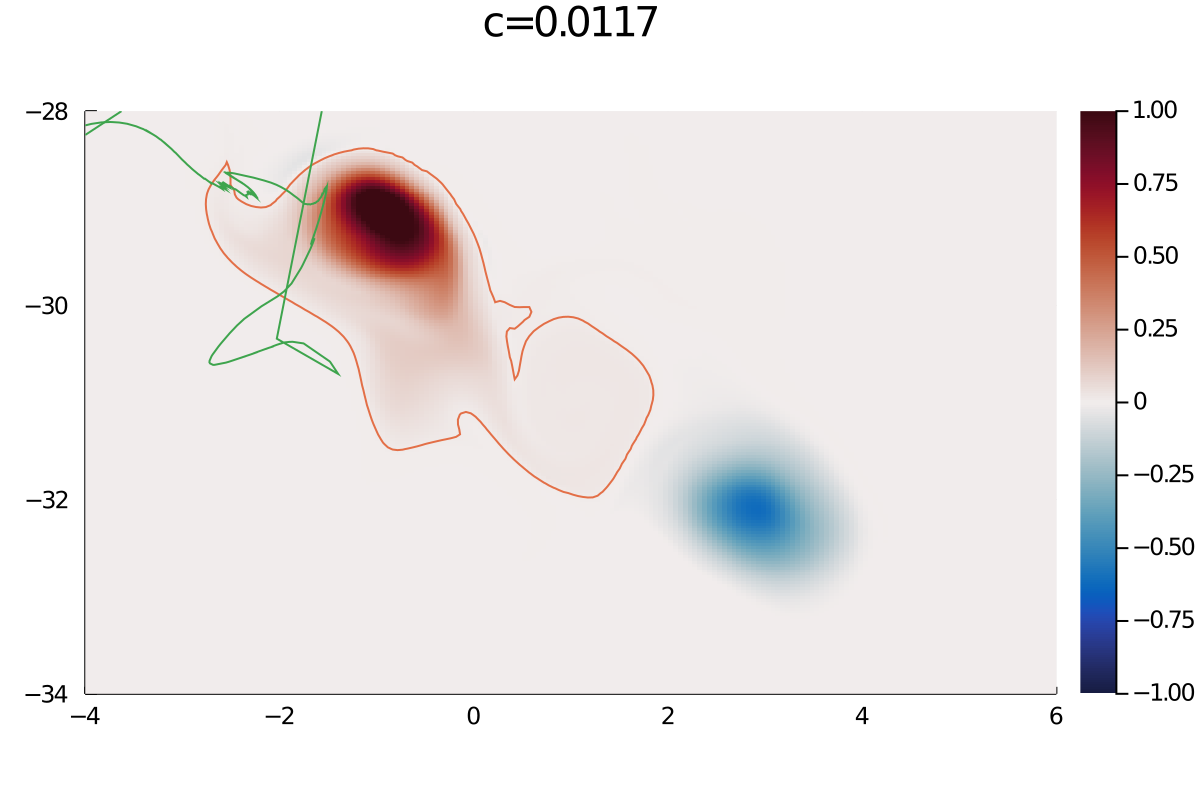

In [36]:
c_best = level(best_levelset)
plot_best = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_best,digits=4))",bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curve = lines(get_levelset(ctx, u₀, c_best, bdata=bdata))[1]
curve = Main.CoherentStructures.closeCurve(ctx,curve)
curve_moved = Main.CoherentStructures.apply2curve(x->T(x,0),curve)

cheeger_value = dynamic_cheeger_value(ctx, curve, x->T(x,0))
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curve))\t",
    "$(Main.CoherentStructures.getLength(curve_moved))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curve))\n")

Plots.plot!(coordinates(curve))
Plots.plot!(coordinates(curve_moved))


Plots.plot!(fmt=:png,dpi=200)

In [25]:
function plot_vectorfield(xs,ys,dx,dy;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    x_coords = repeat(xs, outer=length(ys))
    y_coords = repeat(ys, inner=length(xs))
    dx, dy = scale.*dx[1:step:end,1:step:end], scale.*dy[1:step:end,1:step:end]
    quiver(x_coords,y_coords,quiver=(vec(dx),vec(dy)))
end

plot_vectorfield (generic function with 1 method)

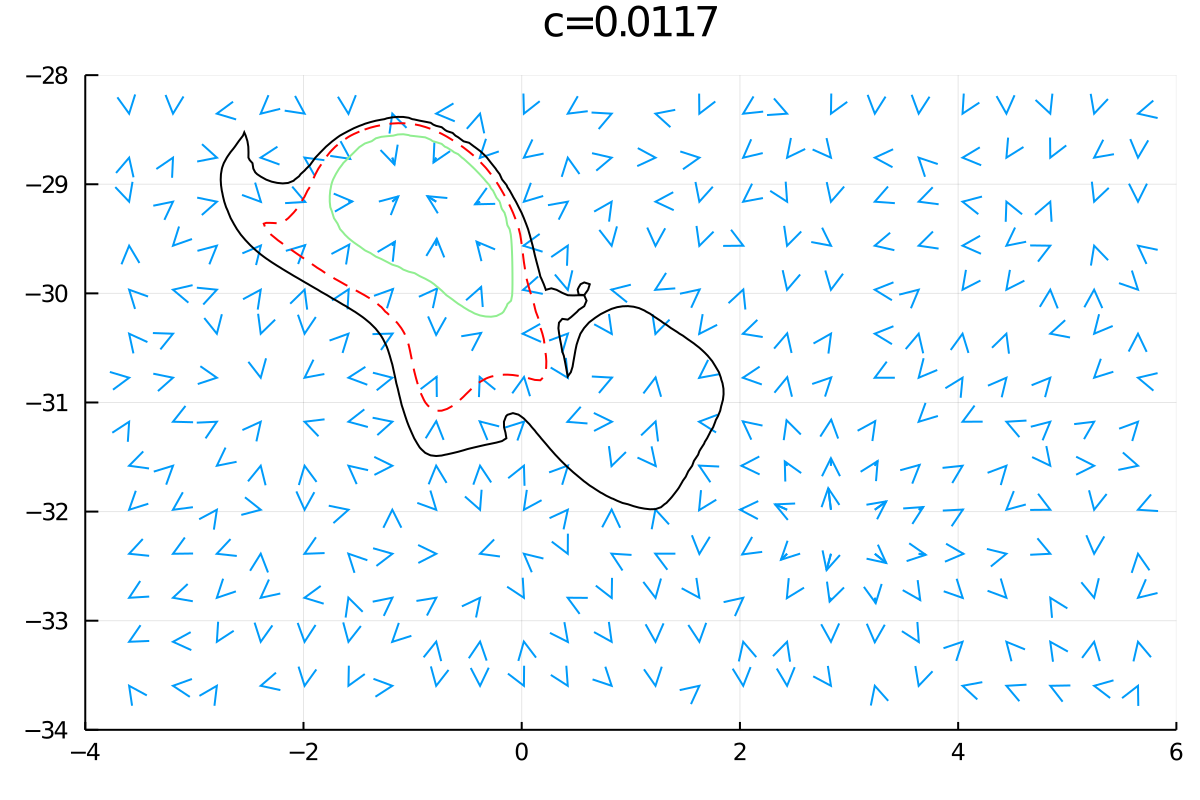

In [31]:
plot_vectorfield(get_levelset_evolution(ctx,u₀,u_dot, bdata=bdata)...,scale=0.1,step=8)
curves         = lines(get_levelset(ctx, u₀, c_best, bdata=bdata))
curves_epsilon = lines(get_levelset(ctx, uϵ, c_best, bdata=bdata))
curves_predicted = lines(get_levelset(ctx, u₀ + ϵ*u_dot, c_best, bdata=bdata))

for c in curves
    plot!(coordinates(c),color=:black)
end
for c in curves_epsilon
    plot!(coordinates(c),color=:red,linestyle=:dash)
end
for c in curves_predicted
    plot!(coordinates(c),color=:lightgreen)
end

Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(-4,6),ylims=(-34,-28),title="c=$(round(c_best,digits=4))")